In [27]:
import os
import numpy as np
import torch
import util
import matplotlib.pyplot as plt
from data import fr
from torch.autograd.gradcheck import zero_gradients
%matplotlib inline

In [28]:
def compute_jacobian_and_bias(inputs, net):
    inputs.requires_grad = True
    outputs = net(inputs)
    
    inp_n1 = inputs.shape[-2]
    inp_n2 = inputs.shape[-1]
    out_n = outputs.shape[-1]
    
    jacobian = torch.zeros([inp_n1, inp_n2, out_n])
    
    for i in range(out_n):
        zero_gradients(inputs)
        outputs[0, i].backward(retain_graph = True)
        # print(jacobian[:, :, i].shape,  inputs.grad.data.shape) [2 ,50] === [1, 2, 50]
        jacobian[:, :, i] = inputs.grad.data[0]
        
    return jacobian.numpy(), inputs.detach().numpy(), outputs.detach().numpy()

def compute_bias(jacobian, inputs, outputs):
    jacobian = jacobian.reshape((100, 1000))
    inputs = inputs.reshape((100))
    pred = jacobian.T.dot(inputs)
    bias = pred.real - outputs
    return bias

def check_bias(fr_module):
    for layer in fr_module.modules():
        if str(layer).startswith('BFBatchNorm1d'):
            x = torch.randn((8,64, 100))
            alpha = 10
            input1 = alpha * layer(x)
            input2 = layer(x * alpha)
            check = (input1 - input2).sum()
            x = torch.zeros((8,64, 100))
            input1 = layer(x)
            print(check.item(), input1.sum().item())

In [29]:
fr_path = 'checkpoint/model_snr_30_bias_yes/fr/epoch_300.pth'
fc_path = 'checkpoint/model_snr_30_bias_yes/fc/epoch_300.pth'
data_dir = 'test_dataset'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#load models
fr_module, _, _, _, _ = util.load(fr_path, 'fr', device)
fc_module, _, _, _, _ = util.load(fc_path, 'fc', device)
fr_module.cpu()
fr_module.eval()
fc_module.cpu()
fc_module.eval()
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)

In [30]:
check_bias(fr_module)

75256.1875 8361.76953125
24429.482421875 2714.377685546875
61959.21484375 6884.38623046875
62425.59375 6936.09716796875
23747.9296875 2638.680419921875
64417.25390625 7157.50341796875
45899.5 5099.92919921875
-62148.31640625 -6905.34033203125
10719.306640625 1191.0274658203125
18152.126953125 2016.900146484375
45541.59765625 5060.17138671875
-30799.220703125 -3422.087646484375
-31853.279296875 -3539.238037109375
-23200.1953125 -2577.795654296875
-18103.447265625 -2011.500732421875
-51037.15625 -5670.79638671875
-39009.109375 -4334.357421875
26677.28125 2964.142578125
-2358.73486328125 -262.0847473144531
9302.298828125 1033.5919189453125


In [31]:
#load data
f = np.load(os.path.join(data_dir, 'f.npy'))
signal_0dB = np.load(os.path.join(data_dir, '0.0dB.npy'))
signal_10dB = np.load(os.path.join(data_dir, '10.0dB.npy'))
signal_50dB = np.load(os.path.join(data_dir, '50.0dB.npy'))
nfreq = nfreq = np.sum(f >= -0.5, axis=1)

### Frequency estimation

In [32]:
idx = 8
inp = torch.as_tensor(signal_10dB[idx][None])

## Compute Jacobian

In [33]:
jacobian, inputs, outputs = compute_jacobian_and_bias(inp, fr_module)
bias = compute_bias(jacobian, inputs, outputs)

In [38]:
bias = bias.reshape(-1)

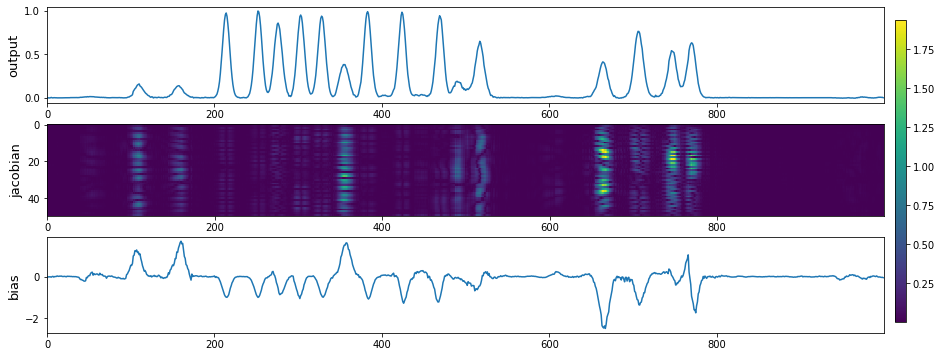

In [39]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6))

ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[0].set_xticklabels(np.arange(0, 1000, 200))
ax[0].set_xlim(-0.5, 0.5)
ax[0].set_ylabel('output', fontsize=13)

im = ax[1].imshow(np.abs(grad))
ax[1].set_aspect(2.2)
ax[1].set_ylabel('jacobian', fontsize=13)

ax[2].plot(xgrid, bias)
ax[2].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[2].set_xticklabels(np.arange(0, 1000, 200))
ax[2].set_xlim(-0.5, 0.5)
ax[2].set_ylabel('bias', fontsize=13)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## Bias Free Model

In [10]:
fr_path = 'checkpoint/model_snr_30_bias_no/fr/epoch_300.pth'
fc_path = 'checkpoint/model_snr_30_bias_no/fc/epoch_300.pth'
data_dir = 'test_dataset'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#load models
fr_module, _, _, _, _ = util.load(fr_path, 'fr', device)
fr_module.cpu()
fr_module.eval()
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)

In [11]:
check_bias(fr_module)

0.00022665911819785833 0.0
-8.475850336253643e-06 0.0
5.5264492402784526e-05 0.0
6.230792496353388e-05 0.0
0.00013460638001561165 0.0
7.39578390493989e-05 0.0
-1.646630698814988e-05 0.0
0.00019134092144668102 0.0
-0.00010218855459243059 0.0
0.0003082860494032502 0.0
-0.00020418013446033 0.0
0.00025848165387287736 0.0
-4.990480374544859e-05 0.0
-6.188756378833205e-05 0.0
-0.000332191470079124 0.0
-0.00014891300816088915 0.0
4.2781466618180275e-05 0.0
6.025178299751133e-05 0.0
0.00031937460880726576 0.0
0.00011816804180853069 0.0


In [23]:
def compute_jacobian_and_bias(inputs, net):
    inputs.requires_grad = True
    outputs = net(inputs)
    
    inp_n1 = inputs.shape[-2]
    inp_n2 = inputs.shape[-1]
    out_n = outputs.shape[-1]
    
    jacobian = torch.zeros([inp_n1, inp_n2, out_n])
    
    for i in range(out_n):
        zero_gradients(inputs)
        outputs[0, i].backward(retain_graph = True)
        # print(jacobian[:, :, i].shape,  inputs.grad.data.shape) [2 ,50] === [1, 2, 50]
        jacobian[:, :, i] = inputs.grad.data[0]
        
    return jacobian.numpy(), inputs.detach().numpy(), outputs.detach().numpy()

def compute_bias(jacobian, inputs, outputs):
    jacobian = jacobian.reshape((100, 1000))
    inputs = inputs.reshape((100))
    pred = jacobian.T.dot(inputs)
    bias = pred.real - outputs
    return bias

In [24]:
jacobian, inputs, outputs = compute_jacobian_and_bias(inp, fr_module)
bias = compute_bias(jacobian, inputs, outputs)

In [32]:
alpha = 1.5
outputs1 = fr_module(alpha * inp)
outputs2 = alpha * fr_module(inp)
(outputs1 - outputs2).abs().max()

tensor(4.4703e-06, grad_fn=<MaxBackward1>)

In [33]:
zero_inputs = torch.zeros(inp.shape)
outputs3 = fr_module(zero_inputs)
print(outputs3.abs().max())

tensor(0., grad_fn=<MaxBackward1>)


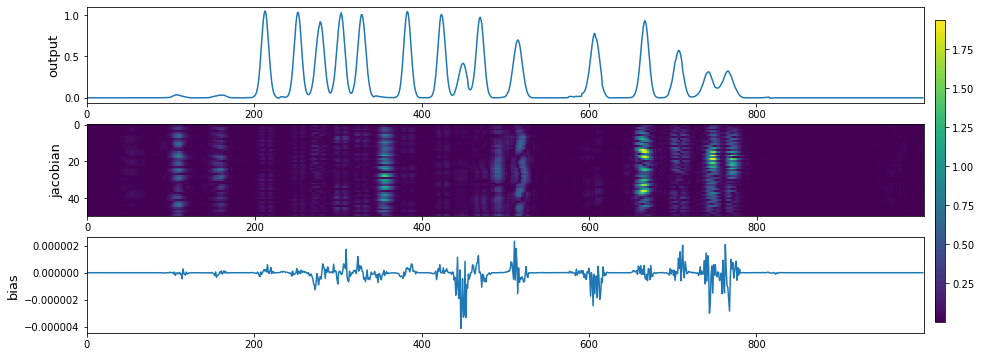

In [26]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6))

ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[0].set_xticklabels(np.arange(0, 1000, 200))
ax[0].set_xlim(-0.5, 0.5)
ax[0].set_ylabel('output', fontsize=13)

im = ax[1].imshow(np.abs(grad))
ax[1].set_aspect(2.2)
ax[1].set_ylabel('jacobian', fontsize=13)

ax[2].plot(xgrid, bias[0])
ax[2].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[2].set_xticklabels(np.arange(0, 1000, 200))
ax[2].set_xlim(-0.5, 0.5)
ax[2].set_ylabel('bias', fontsize=13)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()